import these:

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

print('done')


load data:

In [2]:
(mnist_X, mnist_y), (X_final_te, y_final_te) = tf.keras.datasets.fashion_mnist.load_data()
mnist_y = mnist_y.astype(int)
y_final_te = y_final_te.astype(int)

mnist_X = mnist_X.reshape(60000,28**2) #make each image into a 1d feature vector
X_final_te = X_final_te.reshape(10000,28**2)

print(mnist_X.shape)
print(mnist_y.shape)
print(X_final_te.shape)
print(y_final_te.shape)

training_set_sizes = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
labels = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

s = StandardScaler()
s.fit(mnist_X)
mnist_X = s.transform(mnist_X)

s.fit(X_final_te)
X_final_te = s.transform(X_final_te)

X_tr, X_te, y_tr, y_te = train_test_split(mnist_X, mnist_y, test_size=0.25, shuffle=True)

#use X_tr, y_tr for training
#use X_te, y_te for testing
#use X_final_te, y_final_te for end evaluations




(60000, 784)
(60000,)
(10000, 784)
(10000,)


print some data

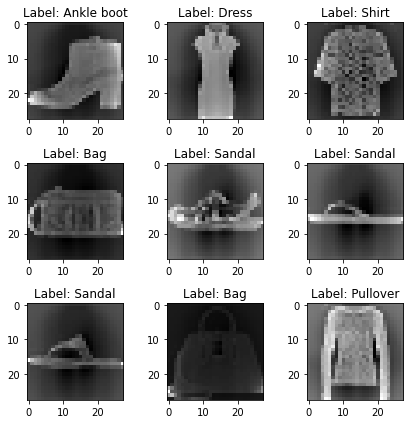

In [13]:
# Some default settings for our plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Create a figure with 3 rows and 3 columns
figure, axes = plt.subplots(3, 3, figsize=(6, 6))  

### YOUR CODE STARTS HERE ###
# Plot the first 9 images in our dataset.
# Include a title on each subplot to indicate the corresponding label.
for x in range(9):
    img = X_tr[x].reshape(28, 28)
    axes[x%3,x//3].imshow(img, cmap="gray")
    label = y_tr[x]
    axes[x%3,x//3].set_title(f'Label: {labels[label]}')


### YOUR CODE ENDS HERE  ###

plt.tight_layout()

tune logistic classifier:

In [4]:
penalty_types = ['l1','l2','elasticnet']
regularization_strengths = [0.001, 0.1, 1, 5, 10, 50]
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
fit_intercept = [True, False]

training_scores = {}
testing_scores = {}

params = []

for p in penalty_types:
    for rs in regularization_strengths:
        for s in solvers:
            for f in fit_intercept:
                params.append((p,rs,s,f))

random.shuffle(params)

#training fNNs on 60k images takes really long, only using first 10k images
sX_tr = X_tr[:10000]
sy_tr = y_tr[:10000]

for i,param in enumerate(params):
    print(f'run {i+1}/{len(params)}: parameters = {param}, ', end='')
    
    clf = LogisticRegression(C=1/param[1], penalty=param[0], solver=param[2],fit_intercept = param[3])
    try:
        clf.fit(sX_tr, sy_tr)
    except:
        print('uh oh')
        continue
    training_scores[param] = clf.score(sX_tr, sy_tr)
    testing_scores[param] = clf.score(X_te, y_te)
    print(f'score = {testing_scores[param]}')
    
#print parameters in order of their scoring
results = [f"{key}, {value}" for (key, value) in sorted(testing_scores.items(), key=lambda x : x[1])]
for i in results:
    print(i)
#('l2', 5, 'sag'), 0.8424
#('l2', 10, 'sag', False), 0.8426

run 1/144: parameters = ('l2', 10, 'newton-cg', False), score = 0.8264666666666667
run 2/144: parameters = ('l1', 50, 'saga', True), score = 0.8137333333333333
run 3/144: parameters = ('l1', 1, 'saga', True), score = 0.8388
run 4/144: parameters = ('l1', 50, 'sag', True), uh oh
run 5/144: parameters = ('l1', 0.1, 'sag', True), uh oh
run 6/144: parameters = ('l1', 0.001, 'lbfgs', False), uh oh
run 7/144: parameters = ('l2', 0.001, 'saga', False), score = 0.8393333333333334
run 8/144: parameters = ('l1', 10, 'lbfgs', False), uh oh
run 9/144: parameters = ('elasticnet', 0.001, 'saga', True), uh oh
run 10/144: parameters = ('l1', 50, 'sag', False), uh oh
run 11/144: parameters = ('l1', 10, 'saga', False), score = 0.8346666666666667
run 12/144: parameters = ('elasticnet', 0.001, 'lbfgs', True), uh oh
run 13/144: parameters = ('l2', 10, 'lbfgs', False), score = 0.8288
run 14/144: parameters = ('l1', 5, 'newton-cg', False), uh oh
run 15/144: parameters = ('elasticnet', 50, 'lbfgs', False), uh

get data for LogisticRegression

start


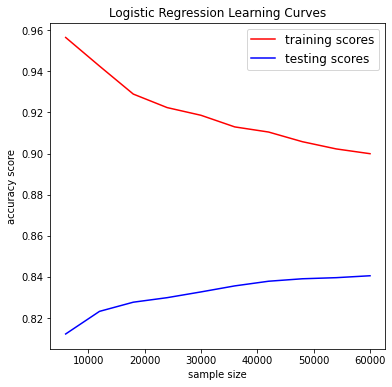

In [10]:
figure, axes = plt.subplots(1, figsize=(6, 6))
p = ('l2', 10, 'sag', False)

print('start')

samples = []
train_acc = []
test_acc = []

clf = LogisticRegression(C=1/param[1], penalty=param[0], solver=param[2],fit_intercept = param[3])
train_size_abs, train_scores, test_scores = learning_curve(clf, X_te, y_te,train_sizes = training_set_sizes)

for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    samples.append(train_size)
    train_acc.append(cv_train_scores.mean())
    test_acc.append(cv_test_scores.mean())

samples = np.array(samples)
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)
    
axes.set_title('Logistic Regression Learning Curves')
axes.plot(samples,train_acc, color = 'red', label = 'training scores')
axes.plot(samples,test_acc, color = 'blue', label = 'testing scores')
axes.set_xlabel("sample size")
axes.set_ylabel("accuracy score")
axes.legend(fontsize=12);
    
    

tune feedforward neural network:

In [ ]:
lrs = [0.001,0.005,0.01,0.05]
activations = ['relu','logistic','tanh','identity']
widths = [250,500,1000]
depths = [3,5,10,15]

training_scores = {}
testing_scores = {}

params = []

for lr in lrs:
    for ac in activations:
        for w in widths:
            for d in depths:
                params.append((lr,ac,w,d))

random.shuffle(params)

#training fNNs on 60k images takes really long, only using first 10k images
sX_tr = X_tr[:10000]
sy_tr = y_tr[:10000]

for i,param in enumerate(params):
    print(f'run {i+1}/{len(params)}: parameters = {param}, ', end='')
    clf = MLPClassifier(hidden_layer_sizes = (param[2],param[3]), activation = param[1], solver = 'sgd', learning_rate_init = param[0])
    clf.fit(sX_tr, sy_tr)
    training_scores[param] = clf.score(sX_tr, sy_tr)
    testing_scores[param] = clf.score(X_te, y_te)
    print(f'score = {testing_scores[param]}')
    
#print parameters in order of their scoring
results = [f"{key}, {value}" for (key, value) in sorted(testing_scores.items(), key=lambda x : x[1])]
for i in results:
    print(i)
    
p = (0.05, 'relu', 500, 15) #score = 0.8674666666666667

get data for fNN:

In [ ]:
figure, axes = plt.subplots(1, figsize=(6, 6))
p = (0.05, 'relu', 500, 15) #score = 0.8674666666666667

print('start')

samples = []
train_acc = []
test_acc = []

clf = MLPClassifier(hidden_layer_sizes = (p[2],p[3]), activation = p[1], solver = 'sgd', learning_rate_init = p[0])
train_size_abs, train_scores, test_scores = learning_curve(clf, X_te, y_te,train_sizes = training_set_sizes)

for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    samples.append(train_size)
    train_acc.append(cv_train_scores.mean())
    test_acc.append(cv_test_scores.mean())
    
samples = np.array(samples)
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)

axes.set_title('fNN Learning Curves')
axes.plot(samples,train_acc, color = 'red', label = 'training scores')
axes.plot(samples,test_acc, color = 'blue', label = 'testing scores')
axes.set_xlabel("sample size")
axes.set_ylabel("accuracy score")
axes.legend(fontsize=12);
    
    

start
